# Module: ptychography

This module contains functions for performing ptychographic phase contrast imaging.

In ptychography [1,2], the projection approximation allows the 4-dimensional dataset $M(\vec{q},\vec{r})$ to be modeled 
as a multiplication of the electron wave function at the specimen plane and a complex-valued transmission function
of the sample. 

$M(\vec{r}',\vec{\rho}) = \left|\int a(\vec{r})T(\vec{r}-\vec{\rho})e^{2\pi i \vec{r} \cdot \vec{r}'}dr\right|^2,$

with $\vec{r}'$ being the diffraction space coordinate of the detector, and $\vec{\rho}$ being the real-space scanning
coordinate.

A Fourier transform along the scanning coordinate $\vec{x}$, and the assumption of a weak phase object $\mathcal{F}T(\vec{\rho}')=\delta(\vec{\rho}') + \Psi_s(\vec{\rho}')$
leads to the description [3]

$G(\vec{r}',\vec{\rho}') = |A(\vec{r}')|^2\delta(\vec{\rho}') + A(r')A^*(r'+\rho')\mathcal{F}T^*(-\rho')+ A^*(r')A(r'-\rho')\mathcal{F}T(\rho'),$

where $A(\vec{r}')$ is the complex-valued aperture function. 

This notebooks shows how to solve for the complex-valued object function T from an experimental dataset M.

References:

[1] Hoppe, W. Beugung im inhomogenen Primärstrahlwellenfeld. I. Prinzip einer Phasenmessung von Elektronenbeungungsinterferenzen. Acta Cryst. A 25, 495–501 (1969).

[2] Rodenburg, J. M. & Bates, R. H. T. The Theory of Super-Resolution Electron Microscopy Via Wigner-Distribution Deconvolution. Philos. Trans. R. Soc. A Math. Phys. Eng. Sci. 339, 521–553 (1992).

[3] Rodenburg, J. M., McCallum, B. C. & Nellist, P. D. Experimental tests on double-resolution coherent imaging via
        STEM. Ultramicroscopy 48, 304–314 (1993).

This notebook demos:
* Recontructing the phase with the weak phase approximation from a calibrated 4D STEM dataset


### Import packages, load data

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import py4DSTEM
from py4DSTEM.process.calibration import get_probe_size
from py4DSTEM.process.dpc import get_CoM_images, get_rotation_and_flip, get_phase_from_CoM
from py4DSTEM.process.dpc import get_wavenumber, get_interaction_constant
from py4DSTEM.file.io import read, h5read
from py4DSTEM.process.utils import Param
from py4DSTEM.process.ptychography import weak_phase_reconstruction
import h5py

In [14]:
# Load data
path = '/home/philipp/projects/direct_ptychography_solvers/'
fn = 'g.h5'
dc = read(path + fn)

#create a dictionary with the metadata and attach it to the datacube. 
# TODO: This should be moved into py4DSTEM at some point

meta = Param(h5read(path + fn, '4D-STEM_data.metadata')['metadata'])
f = h5py.File(path + fn, 'r')
microscope_meta = f['4D-STEM_data/metadata/microscope']
calibration_meta = f['4D-STEM_data/metadata/calibration']

for k in microscope_meta.attrs.keys():
    meta.microscope[k] = microscope_meta.attrs[k]
for k in calibration_meta.attrs.keys():
    meta.calibration[k] = calibration_meta.attrs[k]

dc.metadata = meta

/home/philipp/projects/direct_ptychography_solvers/g.h5 is a py4DSTEM file, v0.3. Reading...


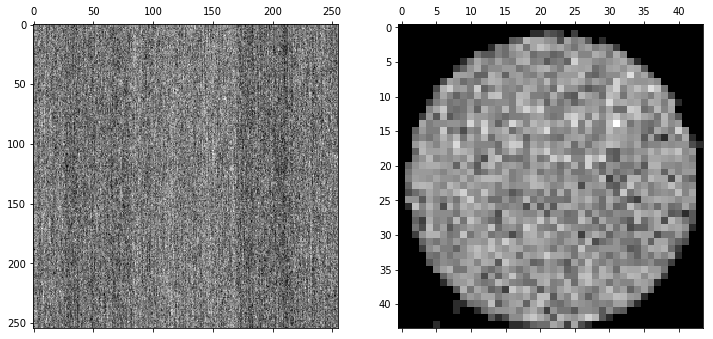

In [15]:
rx,ry = 30,30
power = .5

BF = np.average(dc.data,axis=(2,3))
DP = dc.data[rx,ry,:,:]

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(BF)
ax2.matshow(DP**power)
plt.show()

### Get CBED center and radius

These are used for
1. Calibrating the diffraction plane pixel size
2. Masking the central disk

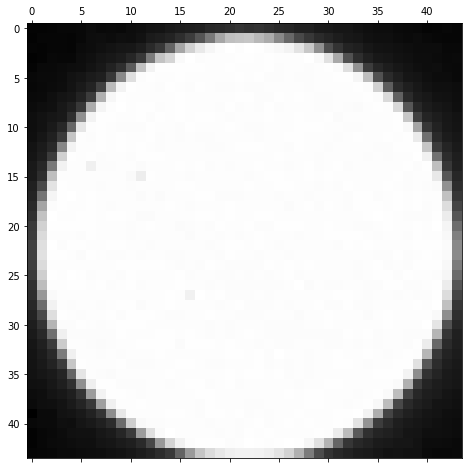

In [16]:
# Get PACBED

power = 0.1

PACBED = np.average(dc.data,axis=(0,1))

# Show
fig,ax = plt.subplots(figsize=(8,8,))
ax.matshow(PACBED**power)
plt.show()

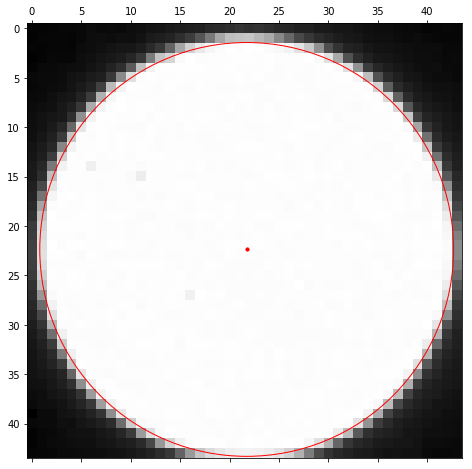

In [17]:
thresh_lower = 0.001
thresh_upper = 0.999
N = 100

r,x0,y0 = get_probe_size(PACBED, thresh_lower=thresh_lower, thresh_upper=thresh_upper, N=N)

# Show
fig,ax = plt.subplots(figsize=(8,8))
ax.matshow(PACBED**power)
ax.scatter(y0,x0,color='r',s=10)
circle = Circle((y0,x0),r,fill=False,edgecolor='r',linewidth=1)
ax.add_patch(circle)
plt.show()

### Get centers of mass

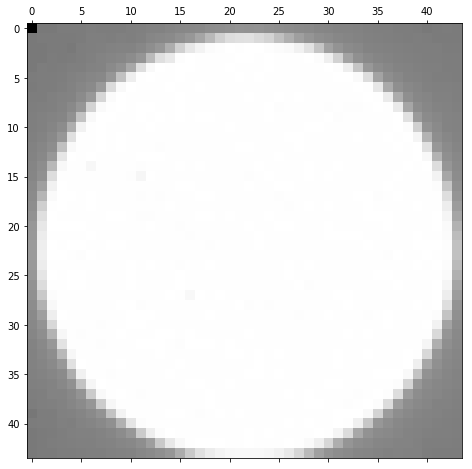

In [18]:
# Get mask

expand = 10

qy,qx = np.meshgrid(np.arange(dc.Q_Ny),np.arange(dc.Q_Nx))
qr = np.hypot(qx-x0,qy-y0)
mask = qr < r + expand

fig,ax = plt.subplots(figsize=(8,8))
ax.matshow((mask*PACBED)**power)
plt.show()

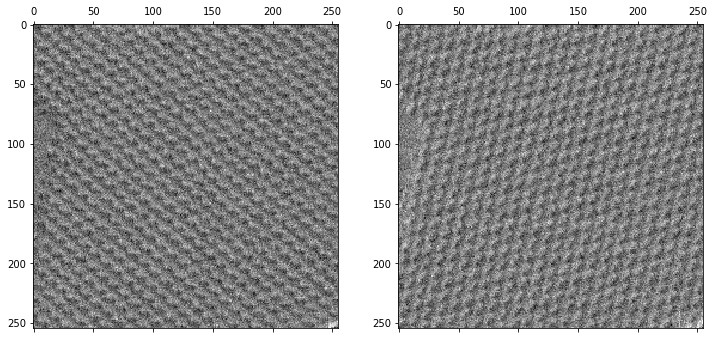

In [19]:
CoMx,CoMy = get_CoM_images(dc, mask=mask, normalize=True)

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.matshow(CoMx)
ax2.matshow(CoMy)
plt.show()

### Get rotation and flip

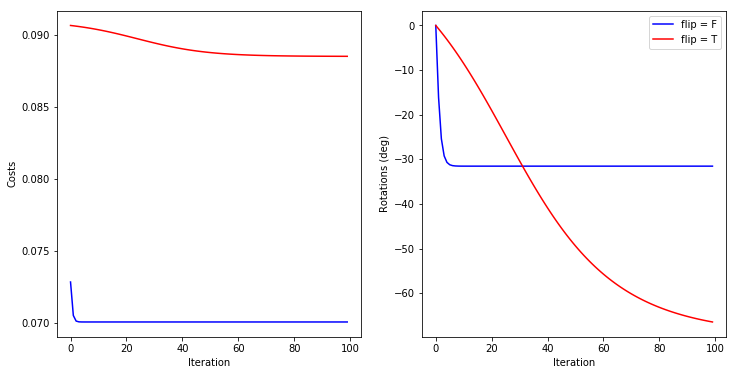

Rotational offset = -31.52 degrees
Flip is set to False


In [20]:
n_iter = 100
stepsize = 4
return_costs = True

theta, flip, thetas, costs, thetas_f, costs_f = get_rotation_and_flip(CoMx, CoMy, dc.Q_Nx, dc.Q_Ny, n_iter=n_iter,
                                                                      stepsize=stepsize, return_costs=return_costs)

# Show
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(np.arange(len(thetas)),costs,color='b')
ax1.plot(np.arange(len(thetas_f)),costs_f,color='r')
ax2.plot(np.arange(len(thetas)),np.degrees(thetas),color='b',label='flip = F')
ax2.plot(np.arange(len(thetas_f)),np.degrees(thetas_f),color='r',label='flip = T')
ax1.set_ylabel("Costs")
ax1.set_xlabel("Iteration")
ax2.set_ylabel("Rotations (deg)")
ax2.set_xlabel("Iteration")
ax2.legend()
plt.show()

print("Rotational offset = {:.4} degrees".format(np.degrees(theta)))
print("Flip is set to {}".format(flip))

### Reconstruction

E               = 80000.0             eV
λ               = 4.2   pm
dR              = [0.205 0.205]             Å
dK              = [0.80361096 0.80361096]           Å
scan       size = [255, 255]
detector   size = [44, 44]
15120.35
29.0
FFT along scan coordinate took 0.0011534811928868294s
SSB took 0.002728060819208622


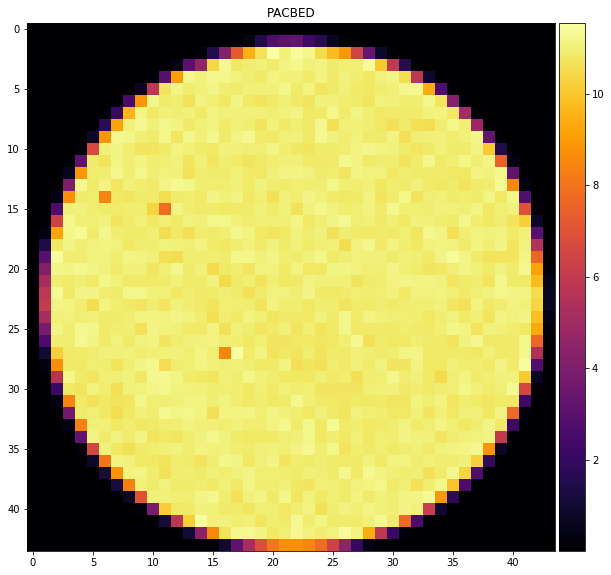

In [21]:
dc.data = dc.data.astype(np.float32)
# dc.data /= np.mean(dc.data, (0,1))
im_ssb, im_ssb1, im_ssb2 = weak_phase_reconstruction(dc, verbose=True, use_cuda=True)

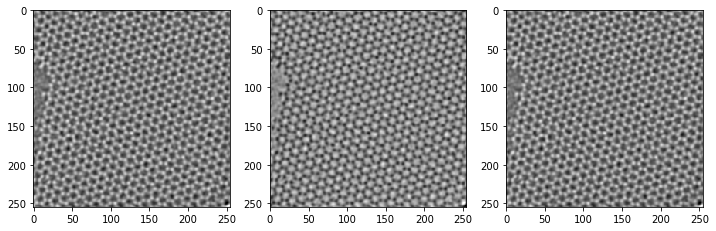

In [23]:
fig,(ax1,ax2, ax3) = plt.subplots(1,3,figsize=(12,6))
ax1.imshow(np.angle(im_ssb))
ax2.imshow(np.angle(im_ssb1))
ax3.imshow(np.angle(im_ssb2))
plt.show()